In [188]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, chi2_contingency, chi2
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, LabelEncoder
import time
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, OneSidedSelection
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, recall_score, precision_score, classification_report

In [189]:
data = pd.read_csv('data/brain_stroke.csv')
data.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


In [190]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4981 entries, 0 to 4980
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             4981 non-null   object 
 1   age                4981 non-null   float64
 2   hypertension       4981 non-null   int64  
 3   heart_disease      4981 non-null   int64  
 4   ever_married       4981 non-null   object 
 5   work_type          4981 non-null   object 
 6   Residence_type     4981 non-null   object 
 7   avg_glucose_level  4981 non-null   float64
 8   bmi                4981 non-null   float64
 9   smoking_status     4981 non-null   object 
 10  stroke             4981 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 428.2+ KB


In [191]:
data.isnull().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

<font size="4">There are no null values</font>

In [192]:
print('data shape before drop duplicated values:', data.shape)
data = data.drop_duplicates()
print('data shape after drop duplicated values:', data.shape)

data shape before drop duplicated values: (4981, 11)
data shape after drop duplicated values: (4981, 11)


<font size="4">There are no duplicated values</font>

# EDA

In [193]:
lst_num = []
lst_cate = ['hypertension', 'heart_disease']
#These are the categorical variables but types are continuous variables

stroke
0    4733
1     248
Name: stroke, dtype: int64


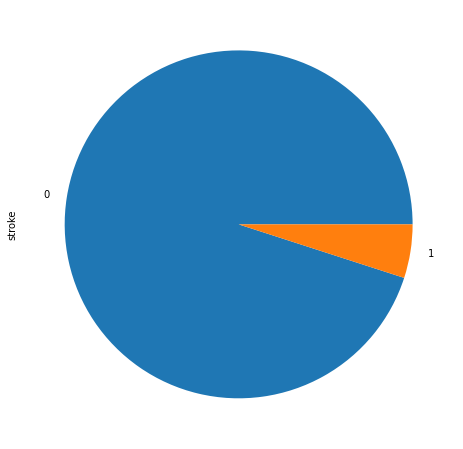

In [194]:
print(data.groupby('stroke')['stroke'].count())
plt.figure(figsize=(8,8))
data.groupby('stroke')['stroke'].count().plot(kind='pie');

<font size="4">Dataset is imbalanced</font>

## Continuous Variables Analysis

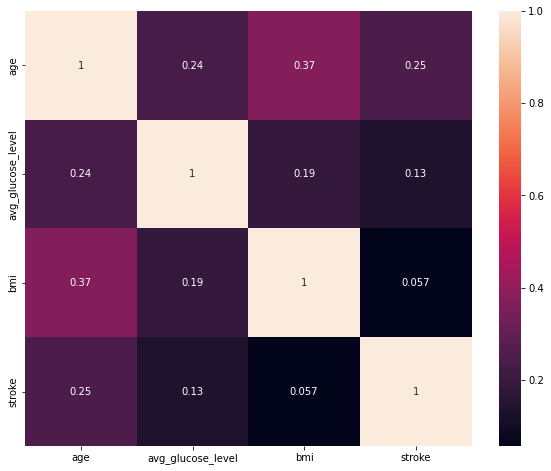

In [195]:
plt.figure(figsize=(10,8))
sns.heatmap(data=data.drop(columns=['hypertension', 'heart_disease']).corr(), annot=True)
plt.show();

<font size="4">As the chart illustrates,</font>
<font size="4">there are no features that have high correlation</font>

In [196]:
lst_num = []
for i in data.columns:
    if(i != 'stroke' and data[i].dtypes != 'O' and i not in lst_cate):
        lst_num.append(i)

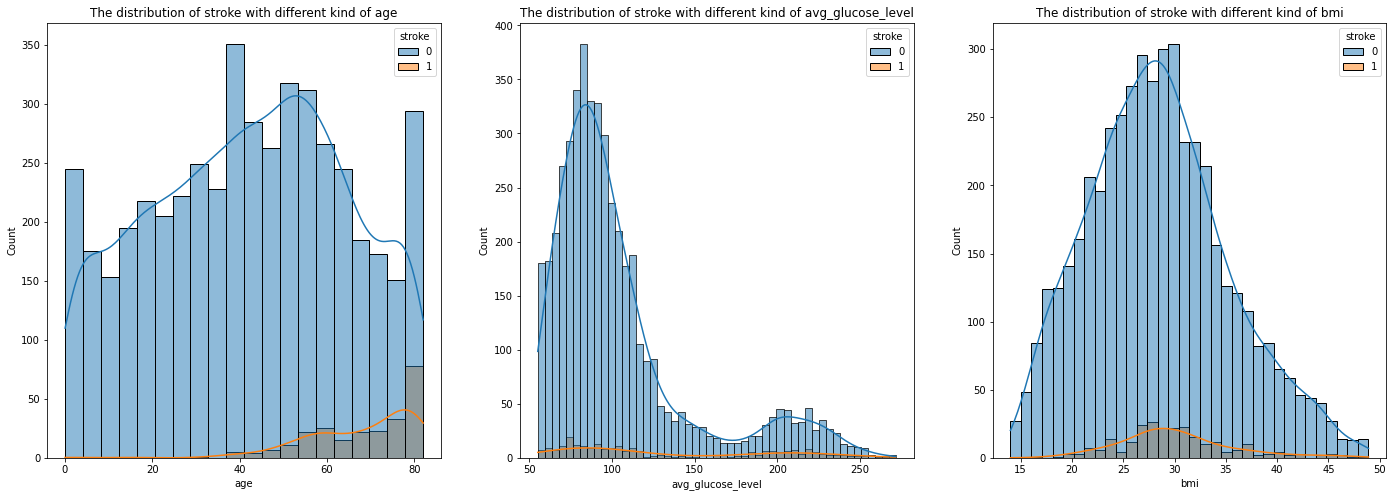

In [197]:
idx = 0
fig, axs = plt.subplots(1, 3, figsize=(24,8))
for i in range(3):
    sns.histplot(ax=axs[i], data=data, x=lst_num[idx], hue='stroke', kde=True)
    axs[i].set_title('The distribution of stroke with different kind of ' + lst_num[idx])
    idx += 1

<font size="4">Most of people who have stroke usually have bmi around 27-32</font>

<font size="4">Most of features are overlapped so it is hard to come to a conclusion</font>

<font size="4">But at bmi graph I can infer that people who have stroke usually have bmi around 27-32</font>

* #------------------------------------------Welch's t-test-------------------------------------------------------#

- H0: There are differences between lst_0 and lst_1 aka mean(lst_0) == mean(lst_1)
- Ha: There are NO differences between lst0 and lst_1 aka mean(lst_0) != mean(lst_1)

* #-------------------------------------------------------------------------------------------------------------------#

In [198]:
alpha = .05
for i in lst_num:
    lst_0 = data[i].loc[data['stroke'] == 0]
    lst_1 = data[i].loc[data['stroke'] == 1]
    t, p = ttest_ind(lst_0, lst_1, equal_var = False)
#--------------------------------------------------------------------------------
    print(f'p-value = {p:.2f}, alpha = {alpha:.2f}')
    if (p < alpha):
        print('p < alpha => reject H0 => there are differences between', i, 'and estroke')
    else:
        print('p > alpha => FAILED to reject H0 => there are NO differences between', i, 'and stroke')
    print('\n')

p-value = 0.00, alpha = 0.05
p < alpha => reject H0 => there are differences between age and estroke


p-value = 0.00, alpha = 0.05
p < alpha => reject H0 => there are differences between avg_glucose_level and estroke


p-value = 0.00, alpha = 0.05
p < alpha => reject H0 => there are differences between bmi and estroke




<font size="4">All features are reject H0, so all the features affect to the stroke condition</font>

## Categorical Variables Analysis

In [199]:
for i in data.columns:
    if(i != 'stroke' and data[i].dtypes == 'O'):
        lst_cate.append(i)

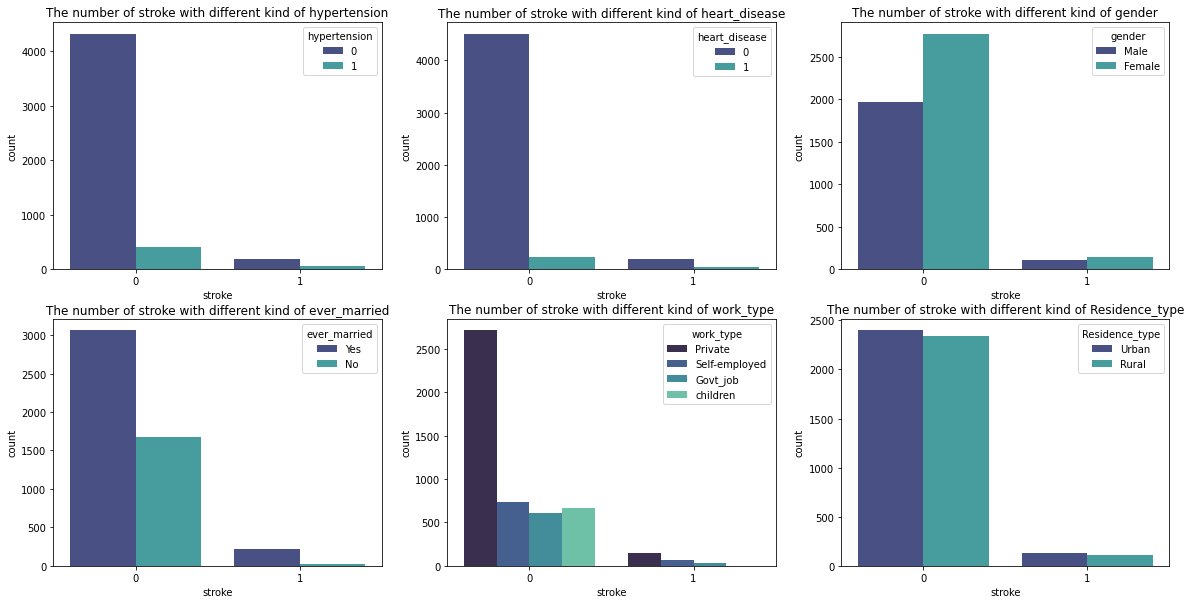

In [200]:
rows = 2
columns = 3
idx = 0
fig, axs = plt.subplots(rows, columns, figsize=(20,10))
for i in range(rows):
    for j in range(columns):
        sns.countplot(ax=axs[i, j], data=data, x='stroke', hue=lst_cate[idx], palette='mako')
        axs[i, j].set_title('The number of stroke with different kind of ' + lst_cate[idx])
        idx += 1

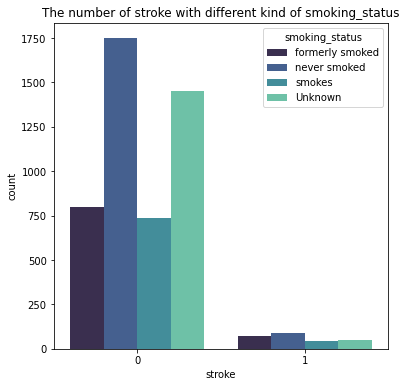

In [201]:
plt.figure(figsize=(6,6))
sns.countplot( data=data, x='stroke', hue=lst_cate[-1], palette='mako')
plt.title('The number of stroke with different kind of ' + lst_cate[-1])
plt.show();

<font size="4">Allow me to do inferential analytics so the conclusion of important features can be made</font>

* #------------------------------------------Chi Square Test-------------------------------------------------------#

- H0: lst_0 and lst_1 are DEPENDENT
- Ha: lst0 and lst_1 are INDEPENDENT

* #-------------------------------------------------------------------------------------------------------------------#

In [202]:
alpha = .05
for i in lst_cate:
    table = pd.crosstab(data[i], data['stroke'])
    stat, p, dof, expected = chi2_contingency(table)
#--------------------------------------------------------------------------------
    print(f'p-value = {p:.2f}, alpha = {alpha:.2f}')
    if (p < alpha):
        print('p < alpha => reject H0 => ', i, 'and stroke are DEPENDENT')
    else:
        print('p > alpha => FAILED to reject H0 =>', i, 'and stroke are INDEPENDENT')
    print('\n')

p-value = 0.00, alpha = 0.05
p < alpha => reject H0 =>  hypertension and stroke are DEPENDENT


p-value = 0.00, alpha = 0.05
p < alpha => reject H0 =>  heart_disease and stroke are DEPENDENT


p-value = 0.58, alpha = 0.05
p > alpha => FAILED to reject H0 => gender and stroke are INDEPENDENT


p-value = 0.00, alpha = 0.05
p < alpha => reject H0 =>  ever_married and stroke are DEPENDENT


p-value = 0.00, alpha = 0.05
p < alpha => reject H0 =>  work_type and stroke are DEPENDENT


p-value = 0.27, alpha = 0.05
p > alpha => FAILED to reject H0 => Residence_type and stroke are INDEPENDENT


p-value = 0.00, alpha = 0.05
p < alpha => reject H0 =>  smoking_status and stroke are DEPENDENT




<font size="4">Most of features are reject H0 meaning they affected to the stroke condition</font>

<font size="4">Except for residence_type and gender failed to reject H0 meaning they have no affection to stroke condition</font>

<font size="4">I remove them from the dataset</font>

In [203]:
final_data = data.drop(columns=['Residence_type', 'gender'])

# Features Transformation

In [204]:
label_encoder = LabelEncoder()
final_data['ever_married'] = label_encoder.fit_transform(final_data['ever_married'])

In [205]:
final_data = pd.get_dummies(final_data, drop_first=True)
final_data.head()

,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,stroke,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,1,228.69,36.6,1,1,0,0,1,0,0
1,80.0,0,1,1,105.92,32.5,1,1,0,0,0,1,0
2,49.0,0,0,1,171.23,34.4,1,1,0,0,0,0,1
3,79.0,1,0,1,174.12,24.0,1,0,1,0,0,1,0
4,81.0,0,0,1,186.21,29.0,1,1,0,0,1,0,0


# Model - Detection

In [206]:
X = final_data.drop(columns=['stroke'])
y = data['stroke']

In [207]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [208]:
label_yes_before = y_train.where(y_train == 1).count()
label_no_before = y_train.where(y_train == 0).count()
print('label yes before:', label_yes_before)
print('label no before:', label_no_before)

label yes before: 173
label no before: 3313


In [209]:
ros = RandomOverSampler()
X_train, y_train = ros.fit_resample(X_train, y_train)

In [210]:
label_yes_after = y_train.where(y_train == 1).count()
label_no_after = y_train.where(y_train == 0).count()
print('label yes after:', label_yes_after)
print('label no after:', label_no_after)

label yes after: 3313
label no after: 3313


In [211]:
mm_scaler = MinMaxScaler()
X_train = mm_scaler.fit_transform(X_train)
X_test = mm_scaler.transform(X_test)

In [212]:
models= [LogisticRegression(), GaussianNB(), KNeighborsClassifier(n_neighbors=11), 
         RandomForestClassifier(), DecisionTreeClassifier(), XGBClassifier(), SVC()]
scores= []
test_score_accuracy = []
test_score_recall = []
test_score_precision = []
train_times = []
names= []

In [213]:
for model in models:
    start= time.time()
    scores.append(cross_val_score(model, X_train, y_train, scoring= 'accuracy', cv= 10).mean())
    end = time.time()
    train_times.append(end-start)
    names.append(model.__class__.__name__)

df= pd.DataFrame(scores, columns=['Score_Test'], index= range(len(models)))
df.insert(1, 'Time_Train', pd.Series(train_times))
df.insert(0, 'Model', pd.Series(names))
df

,Model,Score_Test,Time_Train
0,LogisticRegression,0.787504,0.121675
1,GaussianNB,0.745697,0.019017
2,KNeighborsClassifier,0.887561,0.299286
3,RandomForestClassifier,0.989585,13.935482
4,DecisionTreeClassifier,0.977056,0.963697
5,XGBClassifier,0.977363,1.166839
6,SVC,0.806523,5.872557


In [214]:
for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score_acc = accuracy_score(y_test, y_pred)
    score_recall = recall_score(y_test, y_pred)
    score_precision = precision_score(y_test, y_pred)
    #------------------------------------------------
    test_score_accuracy.append(score_acc)
    test_score_recall.append(score_recall)
    test_score_precision.append(score_precision)
    cm = classification_report(y_test, y_pred)
    print(model.__class__.__name__)
    print(cm, '\n')
df['Test_Score_Accuracy'] = test_score_accuracy
df['Test_Score_Recall'] = test_score_recall
df['Test_Score_Precision'] = test_score_precision
df

LogisticRegression
              precision    recall  f1-score   support

           0       0.98      0.73      0.84      1420
           1       0.13      0.76      0.22        75

    accuracy                           0.73      1495
   macro avg       0.56      0.75      0.53      1495
weighted avg       0.94      0.73      0.81      1495
 

GaussianNB
              precision    recall  f1-score   support

           0       0.99      0.59      0.74      1420
           1       0.10      0.87      0.18        75

    accuracy                           0.60      1495
   macro avg       0.54      0.73      0.46      1495
weighted avg       0.94      0.60      0.71      1495
 

KNeighborsClassifier
              precision    recall  f1-score   support

           0       0.97      0.80      0.88      1420
           1       0.12      0.52      0.20        75

    accuracy                           0.79      1495
   macro avg       0.55      0.66      0.54      1495
weighted avg       

,Model,Score_Test,Time_Train,Test_Score_Accuracy,Test_Score_Recall,Test_Score_Precision
0,LogisticRegression,0.787504,0.121675,0.734448,0.760000,0.130734
1,GaussianNB,0.745697,0.019017,0.604682,0.866667,0.100619
2,KNeighborsClassifier,0.887561,0.299286,0.790635,0.520000,0.123418
3,RandomForestClassifier,0.989585,13.935482,0.940468,0.026667,0.111111
4,DecisionTreeClassifier,0.977056,0.963697,0.923077,0.146667,0.177419
5,XGBClassifier,0.977363,1.166839,0.917726,0.226667,0.207317
6,SVC,0.806523,5.872557,0.745151,0.626667,0.117500


<font size="4">The model should focus on the error type II (the person who really have stroke but the model failed to detect stroke). So I will choose model has high score in recall for class 1(stroke)</font>

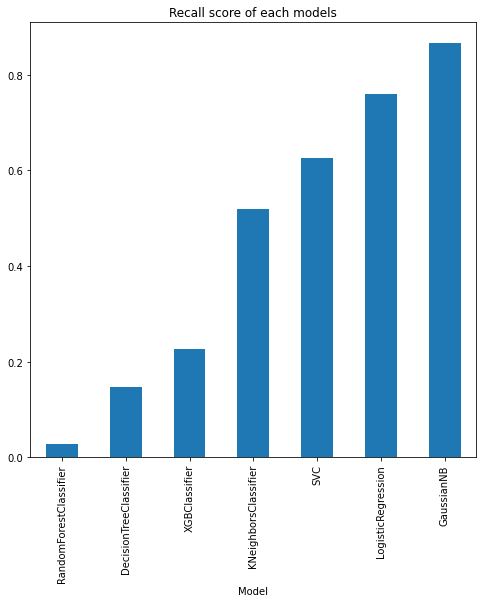

In [229]:
plt.figure(figsize=(8,8))
data=df.groupby(['Model'])['Test_Score_Recall'].mean().sort_values().plot(kind='bar')
plt.title('Recall score of each models')
plt.show()

<font size="4">GaussianNB is the suitable model for the stroke detection from here</font>

# Conclusion

<font size="4">Because of imbalanced dataset, the model may bias the larger classes. However the model is used for prediction or classification in health issues, it should only act as the support for the expert to reduce the workloads, not safe and accuracy enough to use automatically without human intervention.</font>